In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import json
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import NMF
import matplotlib.cm as cm
import umap
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_samples,silhouette_score

import warnings

In [3]:
warnings.filterwarnings('ignore')

def obtain_original_data():
    result = []
    csv_file = pd.read_csv('NIPS_1987-2015.csv')
    for i, column in enumerate(csv_file.columns):
        if i == 0:
            continue
        column_data = csv_file[column].tolist()
        result.append(column_data)
    return result  

def Downscale(type, data, dim):
    result = []
    if type == 0:
        # pca
        pca = PCA(n_components=dim)
        result = pca.fit_transform(data)
    elif type == 1:
        # tsne
        tsne = TSNE(n_components=dim)
        result = tsne.fit_transform(np.array(data))
    elif type == 2:
        # 随机投影 gaussian random projection
        rp = GaussianRandomProjection(n_components=dim)
        result = rp.fit_transform(data)
    elif type == 3:
        # 核主成分分析 kpca
        kpca = KernelPCA(n_components=dim, kernel='rbf')
        result = kpca.fit_transform(data)
    elif type == 4:
        # 独立成分分析 ica
        ica = FastICA(n_components=dim)
        result = ica.fit_transform(data)
    elif type == 5:
        # 稀疏主成分分析 SPCA
        spca = SparsePCA(n_components=dim)
        result = spca.fit_transform(data)
    elif type == 6:
        # 非负矩阵分解 NMF
        nmf = NMF(n_components=dim)
        result = nmf.fit_transform(data)
    else:
        reducer = umap.UMAP(n_components=dim)
        result = reducer.fit_transform(data)
    return result

def save_downscaling_data():
# 提取8种降维数据，存放在downscaling_data.npy中
    original_data = obtain_original_data()
    downscaling_data = []
    for i in range(0, 8):
        print(i)
        downscaling_data.append(Downscale(i, original_data, 3))
    np.save('downscaling_data.npy', np.array(downscaling_data))

    # desiredd put score matrix [[0, 0, 5],[],....] : [method_index,n_cluster,score]
def cluster_papers(data, n_clusters_upper,method_index):
    for n_cluster in range(2,n_clusters_upper,1):

        clusterer = KMeans(n_clusters=n_cluster, random_state=10)  
        cluster_labels = clusterer.fit_predict(data)

        silhouette_avg = silhouette_score(data, cluster_labels)        
    
        score = round(silhouette_avg,5)
        # -2 here is to fit the front end data formate, 
        data_instance = [method_index,n_cluster -2,score]
        score_matrix.append(data_instance)
        
    
def visualize_cluster(data, n_clusters,method_name):

    kmeans = KMeans(n_clusters=n_clusters, random_state=10)  
    kmeans.fit(data)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    ###############################################
    # Do silhouette analysis on the clusters
    # Visualize the results
    
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters

    
    # evaluation - 计算轮廓系数Silhouette Coefficient
    score = silhouette_score(data, labels)
    print("Silhouette score:", score)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax2.scatter(
        data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters

    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with %s downscaling method"
        % method_name,
        fontsize=14,
        fontweight="bold",
    )

    plt.show()
    
    
def obtain_word_requency(nipscsvfile, label):
    # nipscsvfile就是原始文件
    # label是[1, 2, 3, 1, 2, ...]，表示每一个paper的label
    max_value = np.max(label) + 1
    result = []
    words_list = []
    csv_file = pd.read_csv(nipscsvfile)
    for i, column in enumerate(csv_file.columns):
        if i == 0:
            words_list = csv_file[column].tolist()
            result = [[0] * len(csv_file[column].tolist()) for _ in range(max_value)]
            continue
        list_c = csv_file[column].tolist()
        result[label[i-1]] = [x + y for x, y in zip(result[label[i-1]], list_c)]
    return words_list, result

In [ ]:
########################

In [4]:
# get word frequency for UMAP, n=7

data = np.load('downscaling_data.npy', allow_pickle = True)

umap_data = data[-1]

clusterer = KMeans(n_clusters=7, random_state=10)  
cluster_labels = clusterer.fit_predict(umap_data)

silhouette_avg = silhouette_score(umap_data, cluster_labels)        

score = round(silhouette_avg,5)
print(score)

labels = clusterer.labels_

0.36427


In [6]:
words_list, result = obtain_word_requency('NIPS_1987-2015.csv',labels)

In [9]:
result

[[3,
  2,
  122,
  6,
  5,
  54,
  44,
  0,
  4,
  124,
  635,
  25,
  15,
  4,
  23,
  57,
  25,
  248,
  63,
  294,
  18,
  19,
  9,
  4,
  1175,
  38,
  11,
  10,
  7,
  8,
  11,
  129,
  89,
  15,
  20,
  12,
  48,
  11,
  62,
  58,
  38,
  83,
  30,
  26,
  255,
  25,
  6,
  40,
  42,
  17,
  2,
  41,
  103,
  20,
  55,
  980,
  88,
  583,
  47,
  50,
  101,
  43,
  102,
  30,
  30,
  74,
  52,
  47,
  1215,
  408,
  250,
  5,
  11,
  63,
  522,
  724,
  189,
  108,
  12,
  13,
  50,
  70,
  24,
  97,
  279,
  27,
  21,
  242,
  21,
  153,
  36,
  474,
  59,
  161,
  61,
  85,
  5,
  171,
  0,
  843,
  3,
  172,
  4,
  60,
  1062,
  279,
  36,
  88,
  359,
  33,
  36,
  1898,
  445,
  989,
  47,
  439,
  2765,
  49,
  11,
  119,
  695,
  367,
  11,
  12,
  30,
  51,
  14,
  0,
  65,
  26,
  181,
  14,
  806,
  202,
  81,
  1038,
  56,
  8,
  0,
  38,
  0,
  291,
  466,
  362,
  71,
  779,
  825,
  130,
  18,
  315,
  11,
  446,
  44,
  144,
  85,
  44,
  111,
  15,
  77,
  31,
  6

In [10]:
words_list

['abalone',
 'abbeel',
 'abbott',
 'abbreviate',
 'abbreviated',
 'abc',
 'abeles',
 'abernethy',
 'abilistic',
 'abilities',
 'ability',
 'ables',
 'abnormal',
 'abound',
 'abrupt',
 'abs',
 'abscissa',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorbed',
 'absorbing',
 'absorption',
 'abstract',
 'abstraction',
 'abstractions',
 'abstracts',
 'abundance',
 'abundant',
 'abuse',
 'academic',
 'academy',
 'accelerate',
 'accelerated',
 'accelerating',
 'acceleration',
 'accelerations',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessed',
 'accesses',
 'accessible',
 'accommodate',
 'accompanied',
 'accompaniment',
 'accomplish',
 'accomplished',
 'accord',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accounted',
 'accounting',
 'accounts',
 'accumulate',
 'accumulated',
 'accumulates',
 'accumulating',
 'accumulation',
 'accumulator',
 'accuracies',
 'accuracy',
 'accurate',
 'accurately',
 'ace',
 'acetylcholi

In [11]:
cluster_index  = ["0","1","2","3","4","5","6"]
for i in range(7):
    cluster_name = "cluster_" + cluster_index[i]
    freq_word_dict = { 'word':words_list,
                    'frequency': result[i]
                     }

    freq_word_pd = pd.DataFrame(freq_word_dict)

    freq_word_pd.to_csv("/Users/cinder/Desktop/MATH_5473_final/freq_word_"+cluster_name+".csv")

11463
7


In [16]:
# show top 100 frequent words for each cluster
cluster_index  = ["0","1","2","3","4","5","6"]
for i in range(7):
    cluster_name = "cluster_" + cluster_index[i]
    cluster_word_pd = pd.read_csv("/Users/cinder/Desktop/MATH_5473_final/freq_word_"+cluster_name+".csv")
    
    df_sorted = cluster_word_pd.sort_values(by='frequency', ascending=False)
    top_20 = df_sorted.head(20)
    new_df = top_20[['word', 'frequency']]
    new_df = new_df.reset_index(drop=True)
    print(cluster_name)
    print(new_df)

cluster_0
        word  frequency
0    network      19561
1     neural      13875
2   learning      13364
3      input      12198
4       time      11688
5   networks      11585
6      model      11366
7   training      10051
8   function       8177
9     figure       8172
10       set       7973
11    output       7693
12   neurons       7453
13      data       7379
14     using       7187
15    number       6453
16     error       6360
17      used       6312
18     units       6237
19    neuron       5819
cluster_1
         word  frequency
0        data      18594
1    learning      14389
2      matrix      14093
3   algorithm      12777
4         set      12443
5      kernel      11755
6     problem      11616
7       using       9664
8    function       9536
9      number       8197
10      model       7493
11     method       7474
12    results       7287
13      error       6790
14      given       6788
15      based       6749
16       also       6745
17    methods       6718
1

In [ ]:
#########################

In [103]:
# save_downscaling_data()
# Visualize the results


data = np.load('downscaling_data.npy', allow_pickle = True)
method_list = ["PCA","TSNE","Gaussian Random Projection", "Kernel PCA", "Fast ICA","Sparse PCA","NMF","UMAP"]

score_matrix = []
for i, d in enumerate(data):
    cluster_papers(d, 11,i)


In [104]:
score_matrix

[[0, 0, 0.27732],
 [0, 1, 0.33537],
 [0, 2, 0.34634],
 [0, 3, 0.27386],
 [0, 4, 0.29446],
 [0, 5, 0.26532],
 [0, 6, 0.25749],
 [0, 7, 0.26476],
 [0, 8, 0.26661],
 [1, 0, 0.25212],
 [1, 1, 0.24675],
 [1, 2, 0.25236],
 [1, 3, 0.25468],
 [1, 4, 0.26337],
 [1, 5, 0.26572],
 [1, 6, 0.25293],
 [1, 7, 0.24948],
 [1, 8, 0.24557],
 [2, 0, 0.22104],
 [2, 1, 0.21584],
 [2, 2, 0.21968],
 [2, 3, 0.216],
 [2, 4, 0.20764],
 [2, 5, 0.20637],
 [2, 6, 0.20771],
 [2, 7, 0.20361],
 [2, 8, 0.20974],
 [3, 0, 0.43769],
 [3, 1, 0.33697],
 [3, 2, 0.34276],
 [3, 3, 0.34971],
 [3, 4, 0.33397],
 [3, 5, 0.3257],
 [3, 6, 0.30687],
 [3, 7, 0.31112],
 [3, 8, 0.3063],
 [4, 0, 0.24986],
 [4, 1, 0.30885],
 [4, 2, 0.33374],
 [4, 3, 0.31522],
 [4, 4, 0.28035],
 [4, 5, 0.2695],
 [4, 6, 0.27046],
 [4, 7, 0.26615],
 [4, 8, 0.26857],
 [5, 0, 0.2887],
 [5, 1, 0.33466],
 [5, 2, 0.34789],
 [5, 3, 0.2728],
 [5, 4, 0.27141],
 [5, 5, 0.26443],
 [5, 6, 0.25834],
 [5, 7, 0.26574],
 [5, 8, 0.26998],
 [6, 0, 0.34011],
 [6, 1, 0.42037],

Silhouette score: 0.26531637355439636


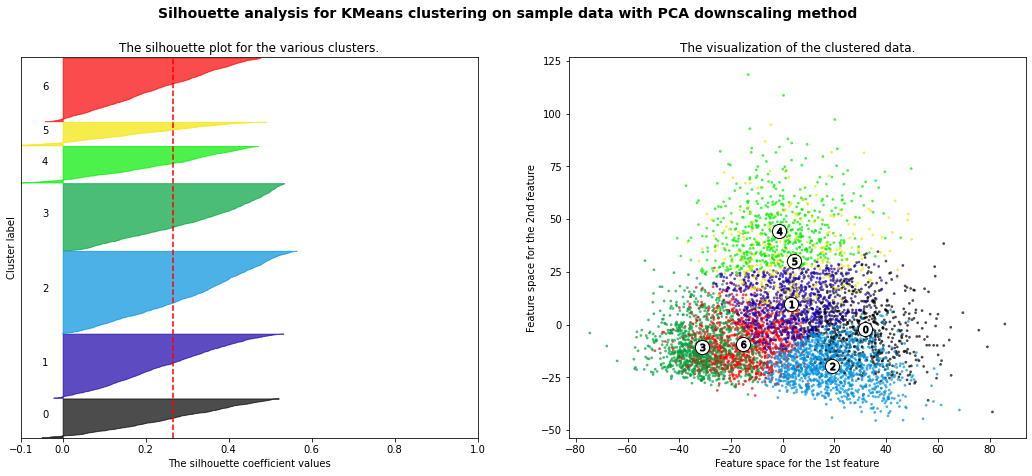

Silhouette score: 0.2657183349391254


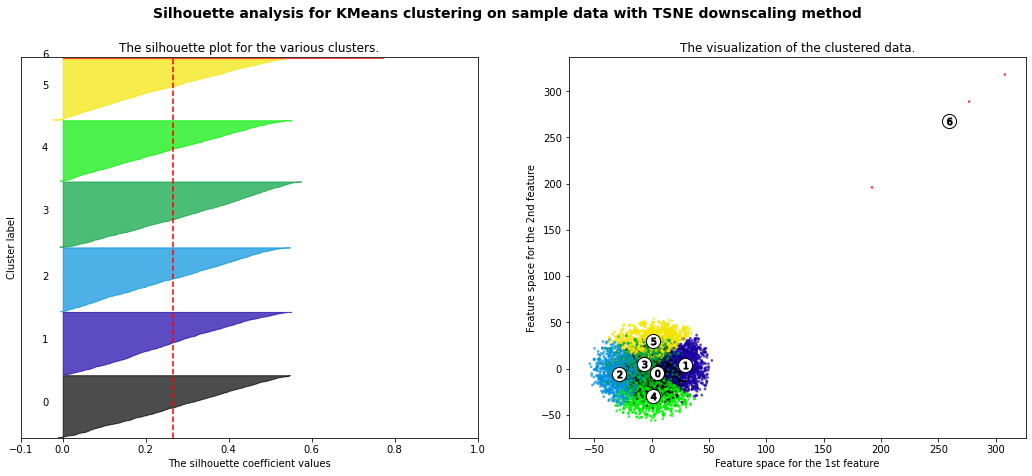

Silhouette score: 0.2063727758433733


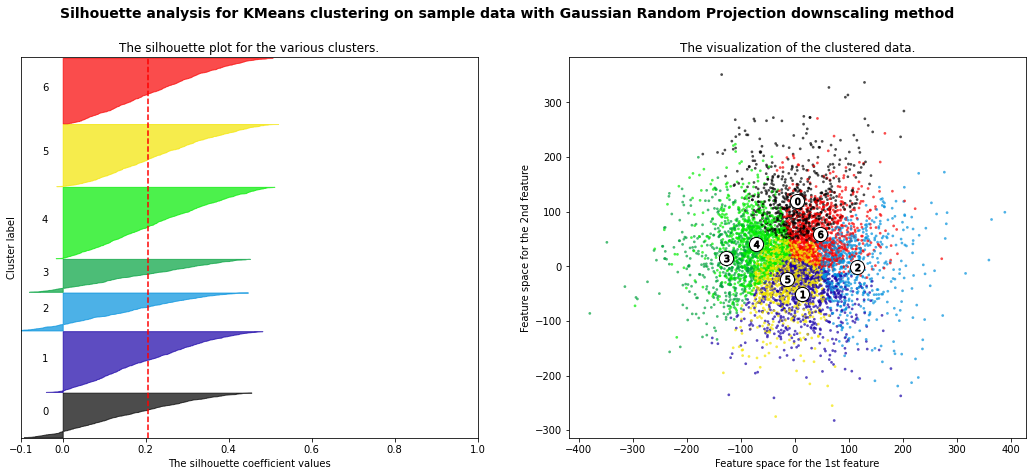

Silhouette score: 0.3256960853698091


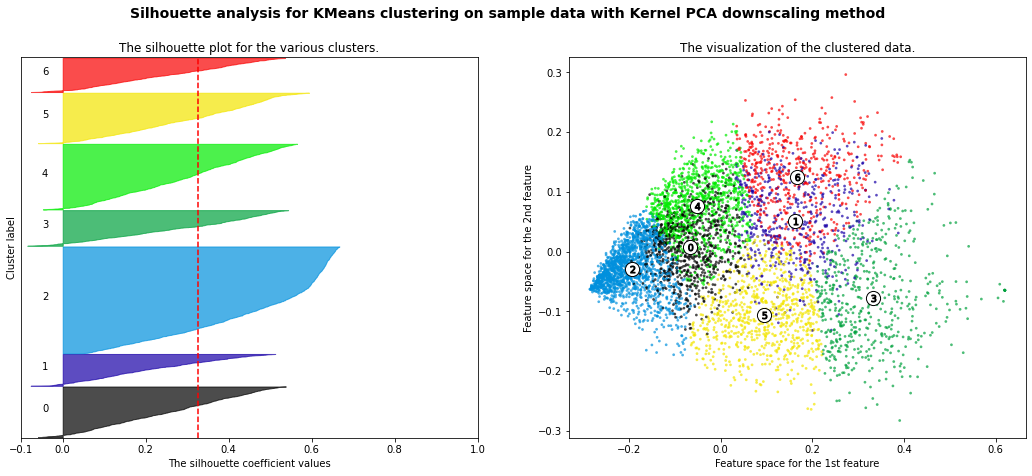

Silhouette score: 0.2695035737227676


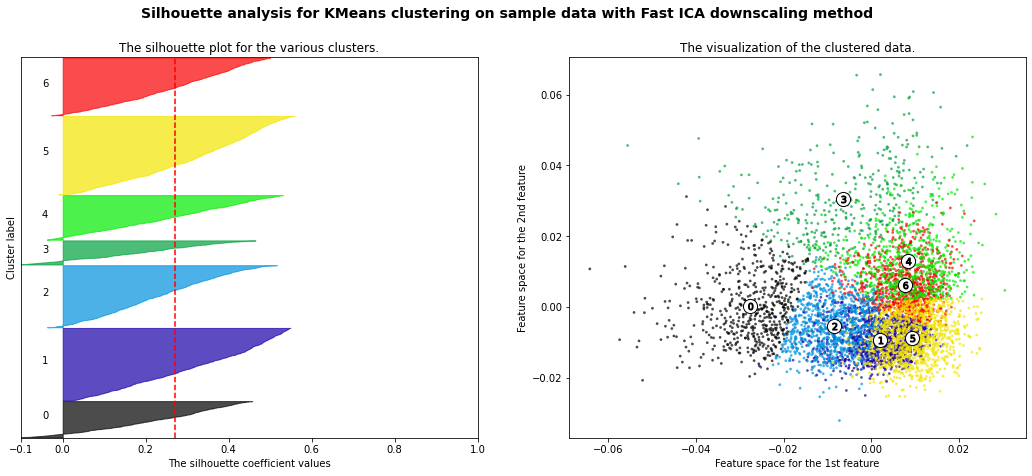

Silhouette score: 0.26443447462326763


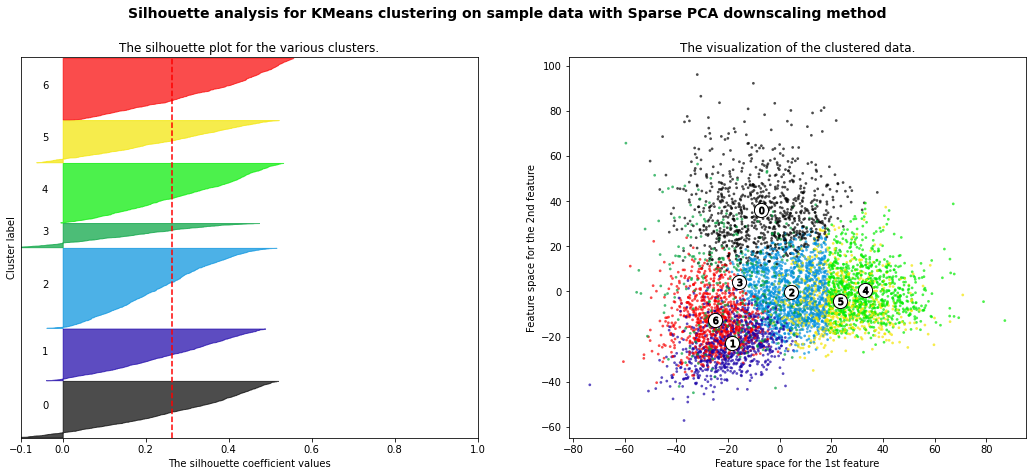

Silhouette score: 0.3022811998816841


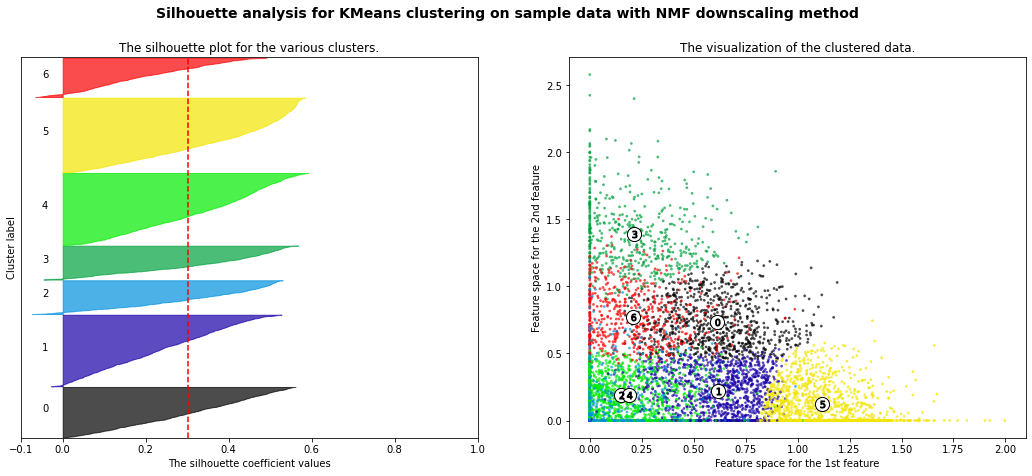

Silhouette score: 0.3642705429483427


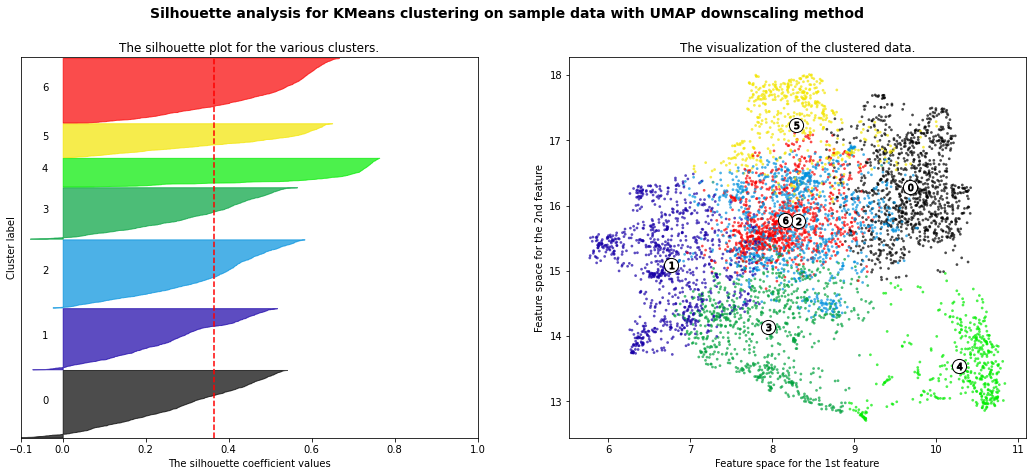

In [106]:
visualize_cluster
for i, d in enumerate(data):
    visualize_cluster(d,7,method_list[i])

Silhouette score: 0.29446140402201265


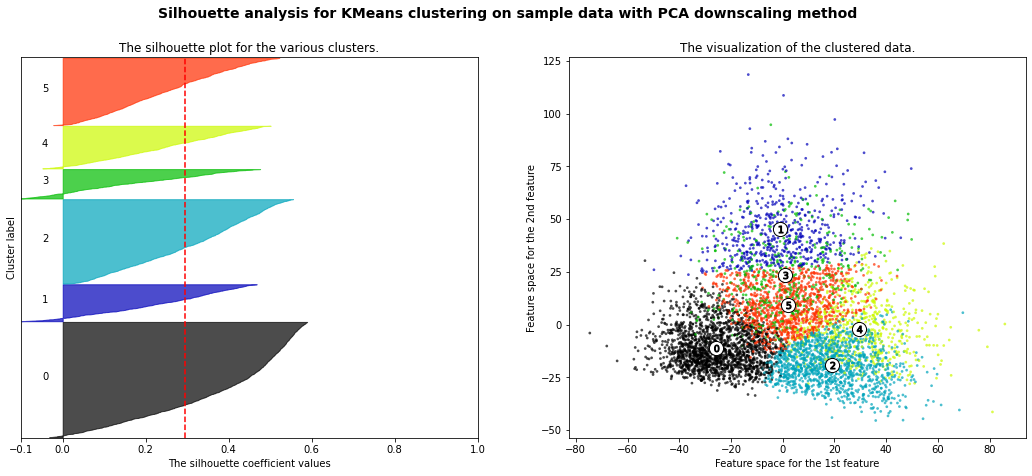

Silhouette score: 0.26337158057060295


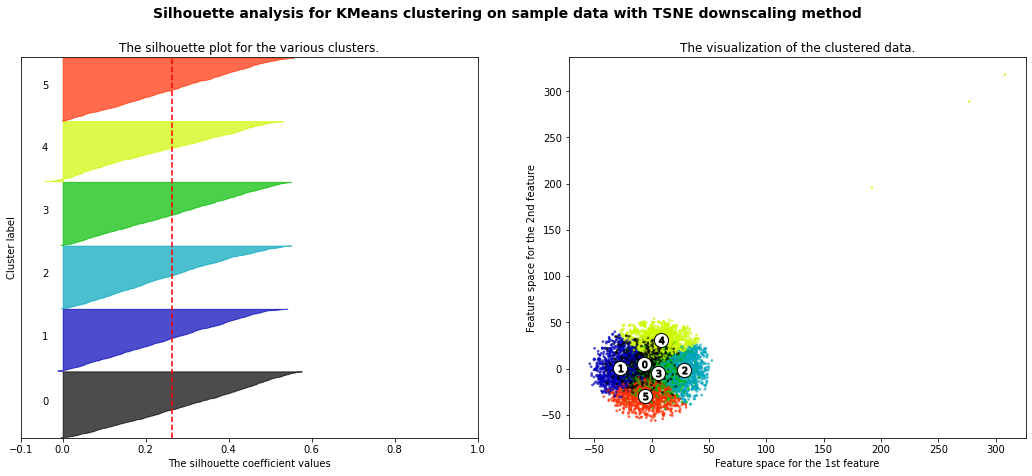

Silhouette score: 0.20764163786407341


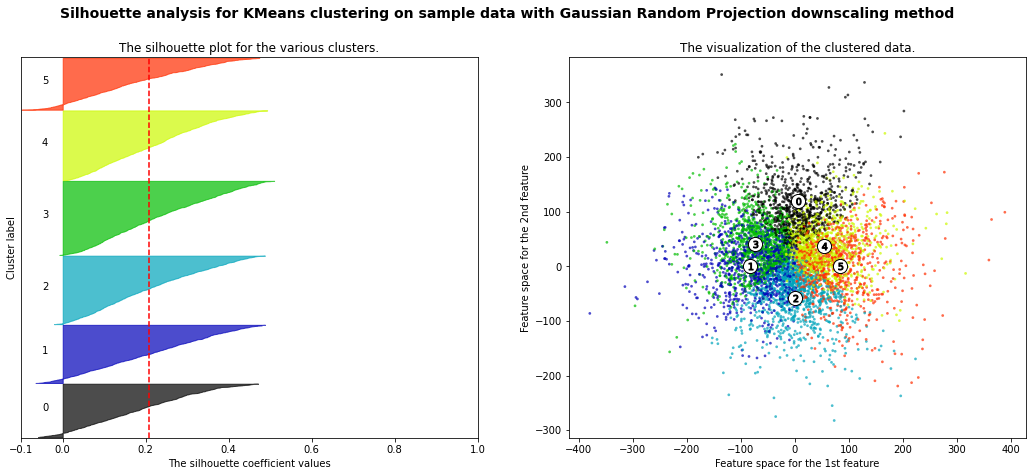

Silhouette score: 0.33397434964100614


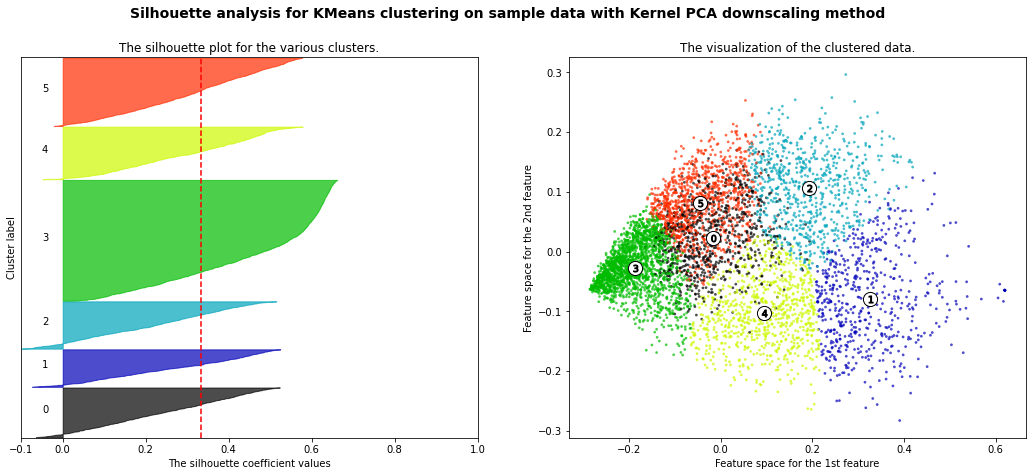

Silhouette score: 0.2803473929448216


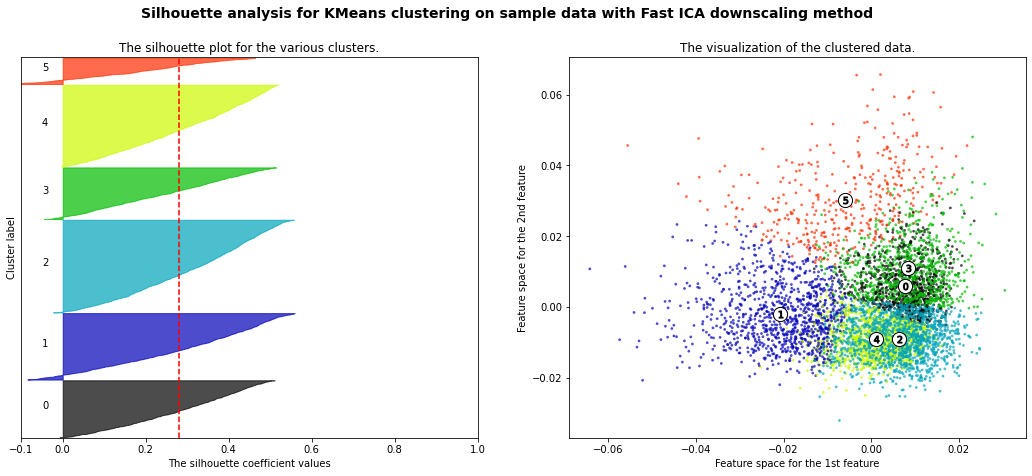

Silhouette score: 0.27140614149558295


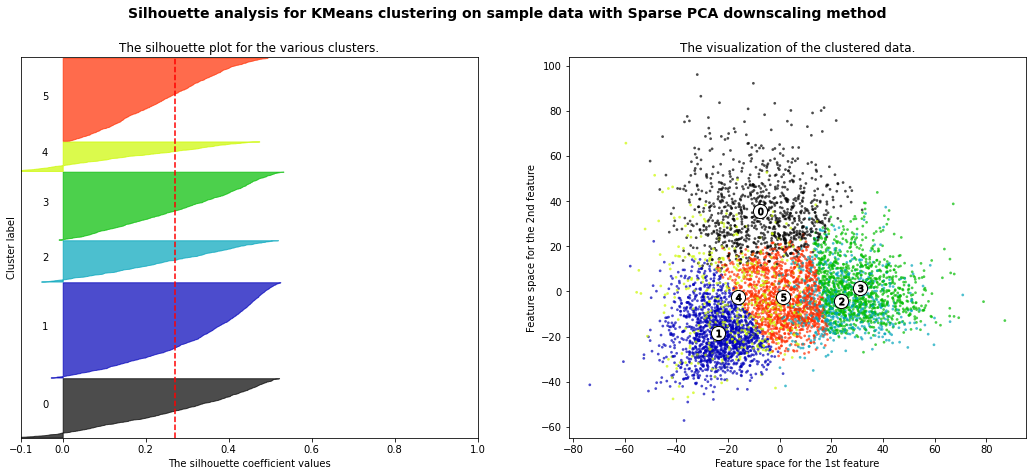

Silhouette score: 0.29451469840453653


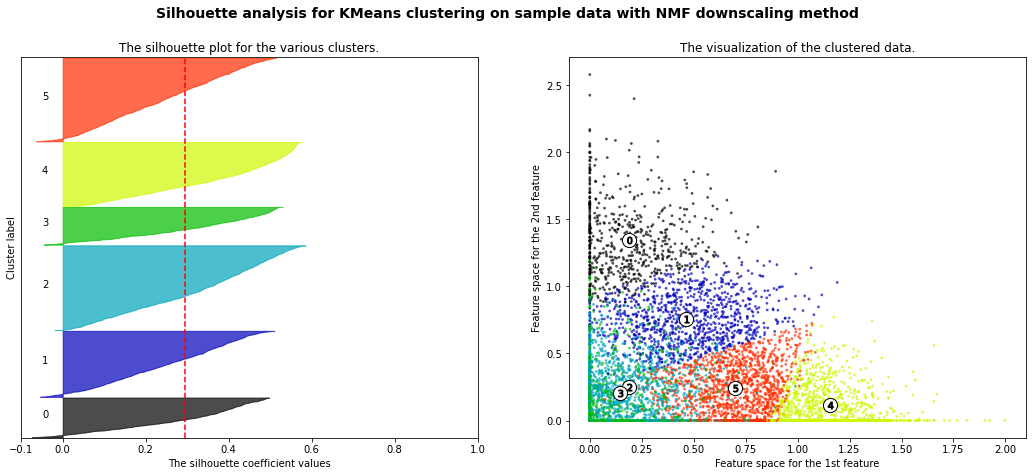

Silhouette score: 0.35173202039748336


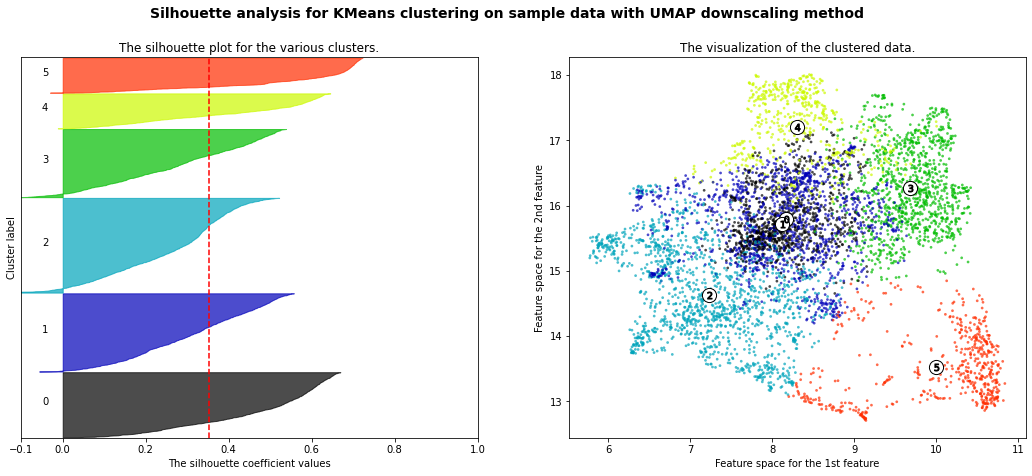

In [107]:
visualize_cluster
for i, d in enumerate(data):
    visualize_cluster(d,6,method_list[i])

Silhouette score: 0.25748583617636245


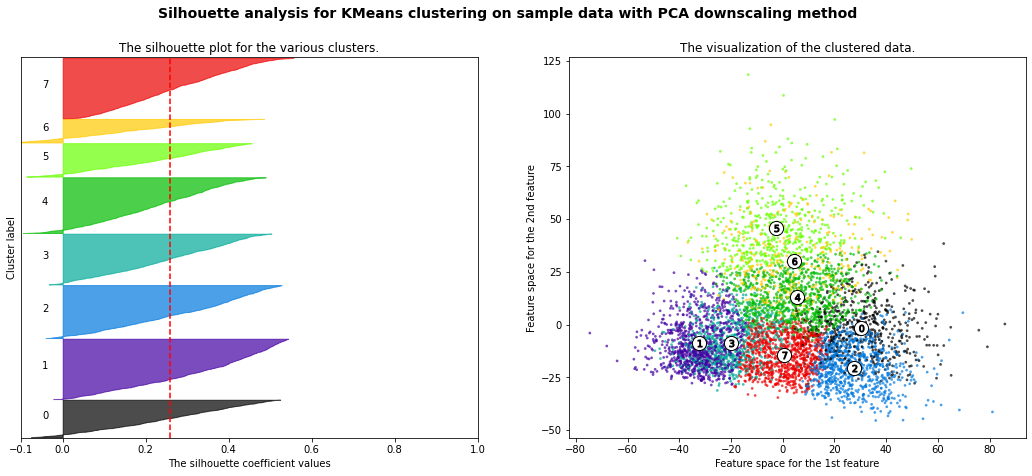

Silhouette score: 0.2529305033765971


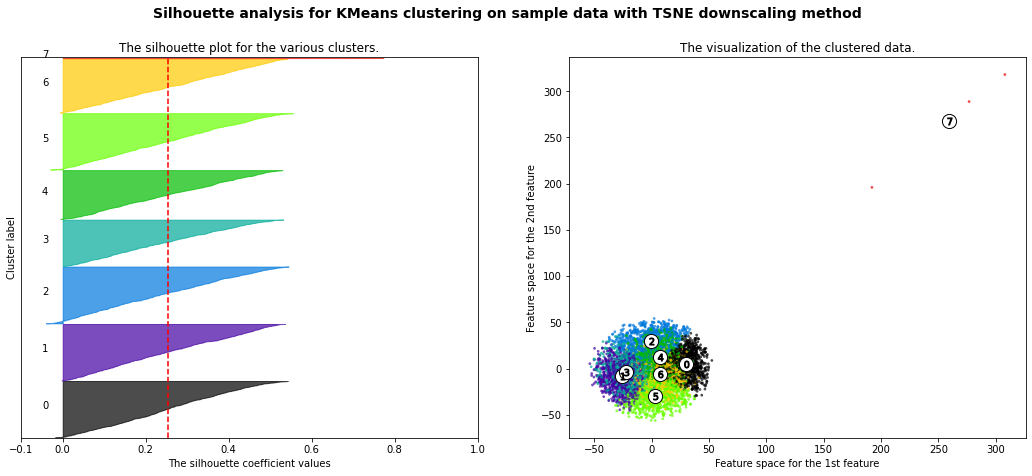

Silhouette score: 0.20770834217874096


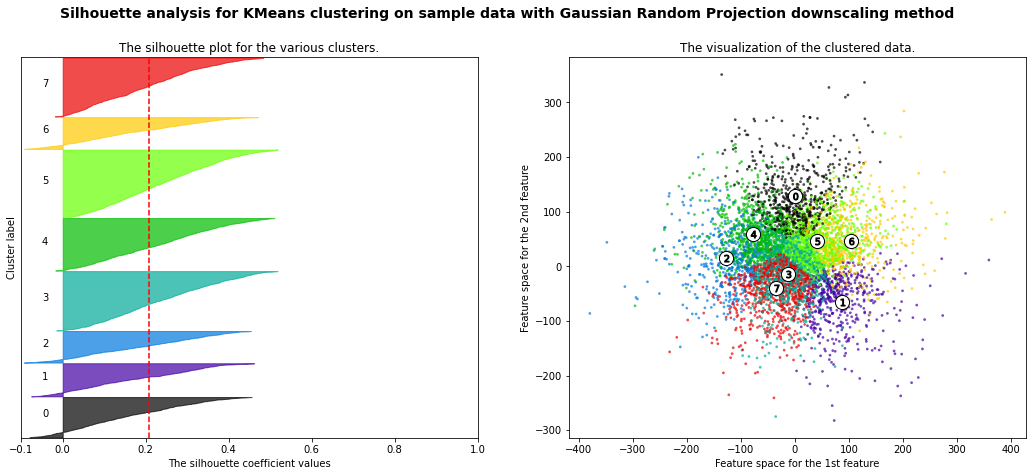

Silhouette score: 0.3068747479575475


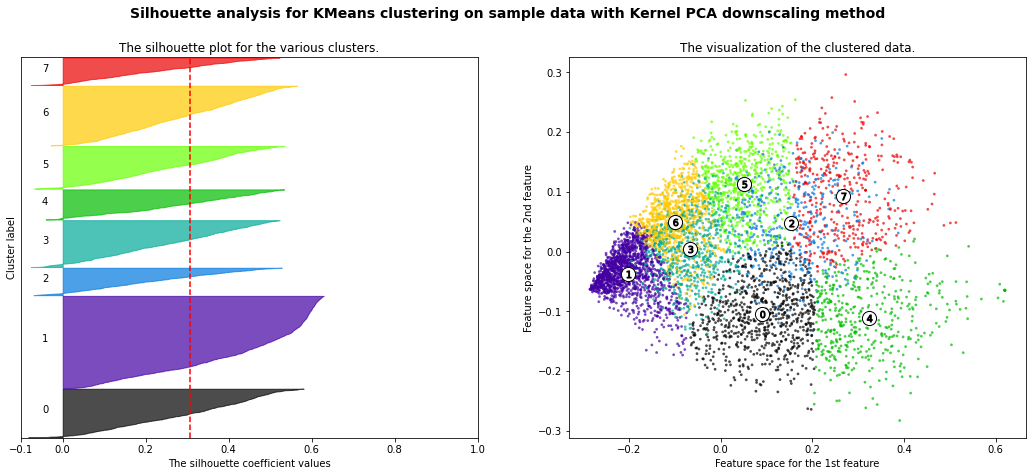

Silhouette score: 0.2704594770663966


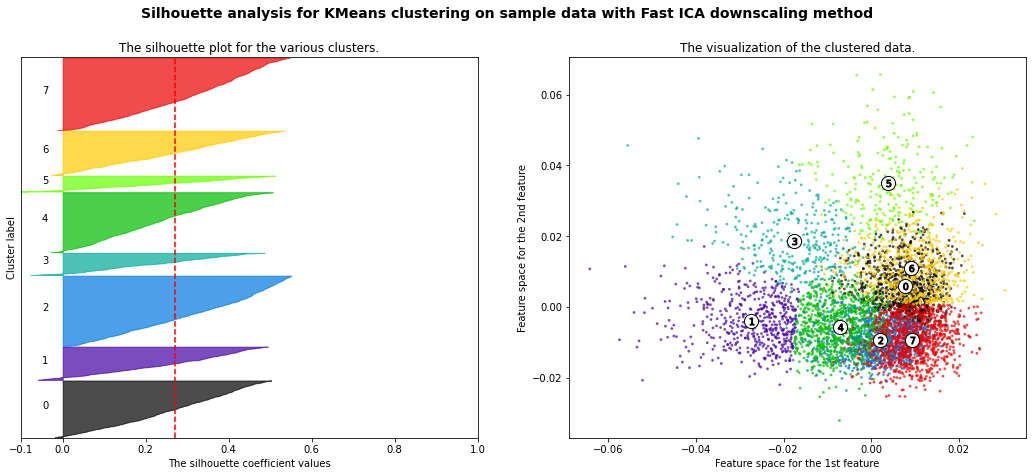

Silhouette score: 0.2583357117969243


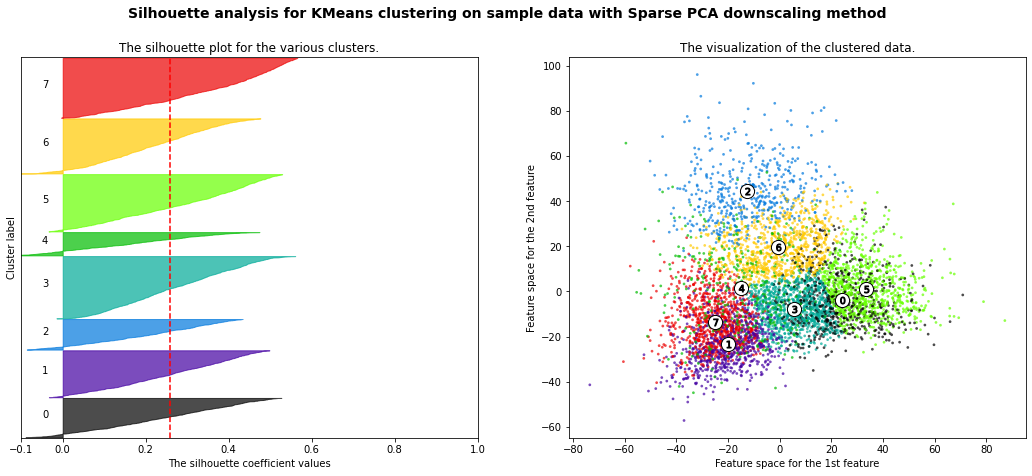

Silhouette score: 0.2828530820856129


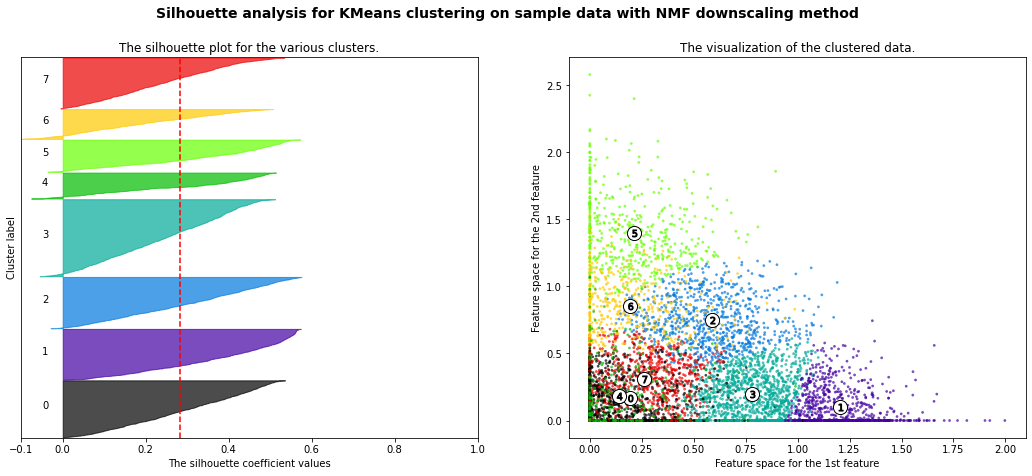

Silhouette score: 0.37280279073366257


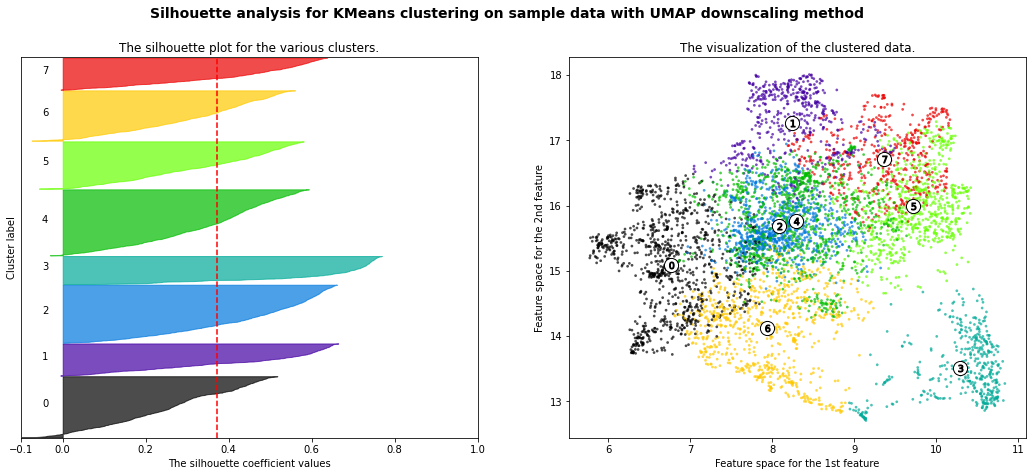

In [108]:
visualize_cluster
for i, d in enumerate(data):
    visualize_cluster(d,8,method_list[i])

In [110]:
##############################
# Below is data transformation for sankey chart

In [111]:
csv_file = pd.read_csv('NIPS_1987-2015.csv')
paper_names = csv_file.columns.values.tolist()
paper_names.pop(0)

paper_names

['1987_1',
 '1987_2',
 '1987_3',
 '1987_4',
 '1987_5',
 '1987_6',
 '1987_7',
 '1987_8',
 '1987_9',
 '1987_10',
 '1987_11',
 '1987_12',
 '1987_13',
 '1987_14',
 '1987_15',
 '1987_16',
 '1987_17',
 '1987_18',
 '1987_19',
 '1987_20',
 '1987_21',
 '1987_22',
 '1987_23',
 '1987_24',
 '1987_25',
 '1987_26',
 '1987_27',
 '1987_28',
 '1987_29',
 '1987_30',
 '1987_31',
 '1987_32',
 '1987_33',
 '1987_34',
 '1987_35',
 '1987_36',
 '1987_37',
 '1987_38',
 '1987_39',
 '1987_40',
 '1987_41',
 '1987_42',
 '1987_43',
 '1987_44',
 '1987_45',
 '1987_46',
 '1987_47',
 '1987_48',
 '1987_49',
 '1987_50',
 '1987_51',
 '1987_52',
 '1987_53',
 '1987_54',
 '1987_55',
 '1987_56',
 '1987_57',
 '1987_58',
 '1987_59',
 '1987_60',
 '1987_61',
 '1987_62',
 '1987_63',
 '1987_64',
 '1987_65',
 '1987_66',
 '1987_67',
 '1987_68',
 '1987_69',
 '1987_70',
 '1987_71',
 '1987_72',
 '1987_73',
 '1987_74',
 '1987_75',
 '1987_76',
 '1987_77',
 '1987_78',
 '1987_79',
 '1987_80',
 '1987_81',
 '1987_82',
 '1987_83',
 '1987_84',
 

In [129]:
import re

paper_year = [int(re.sub(r'_\d+', '', s)) for s in paper_names]
def year_range_transfor(year):
    if year <= 1991:
        class_index = 0
    elif year > 1991 and year <= 1996:
        class_index = 1
    elif year > 1996 and year <= 2001:
        class_index = 2
    elif year > 2001 and year <= 2006:
        class_index = 3
    elif year > 2006 and year <= 2011:
        class_index = 4
    elif year > 2011:
        class_index = 5
    return class_index
paper_year_range = [ year_range_transfor(s) for s in paper_year]
paper_year_range

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [113]:
# get the best cluster result
best_data = data[7]
kmeans = KMeans(n_clusters=7, random_state=10)  
kmeans.fit(best_data)
labels = kmeans.labels_

best_labels = labels.tolist()

In [130]:
paper_dict = { 'paper_index':paper_names,
                'cluster': best_labels,  
                'year': paper_year,
             'year_range':paper_year_range}

In [131]:
paper_summary = pd.DataFrame(paper_dict)

In [132]:
paper_summary.to_csv("/Users/cinder/Desktop/MATH_5473_final/paper_cluster.csv")

In [133]:
# some basic statistic to get data for sankey

paper_summary

paper_index  cluster  year  year_range
0         1987_1        0  1987           0
1         1987_2        0  1987           0
2         1987_3        0  1987           0
3         1987_4        0  1987           0
4         1987_5        0  1987           0
...          ...      ...   ...         ...
5806    2015_399        3  2015           5
5807    2015_400        4  2015           5
5808    2015_401        4  2015           5
5809    2015_402        3  2015           5
5810    2015_403        2  2015           5

[5811 rows x 4 columns]

In [134]:
paper_year_summary = paper_summary.groupby(["year_range","cluster"]).agg({"cluster":"count"})
paper_year_summary

cluster
year_range cluster         
0          0            315
           1              2
           2              9
           3             12
           4             13
           5             26
           6            196
1          0            281
           1             12
           2             62
           3             40
           4             48
           5             37
           6            235
2          0            122
           1             57
           2            113
           3             60
           4             67
           5             60
           6            211
3          0             99
           1            190
           2            188
           3            122
           4             64
           5            120
           6            183
4          0            103
           1            308
           2            304
           3            235
           4            125
           5            154
           6             97
5          0            121
           1            378
           2            379
           3            328
           4            128
           5            129
           6             78

In [135]:
paper_year_summary.to_csv("/Users/cinder/Desktop/MATH_5473_final/paper_year_summary.csv")

In [137]:
paper_year_summary['cluster'].values

array([315,   2,   9,  12,  13,  26, 196, 281,  12,  62,  40,  48,  37,
       235, 122,  57, 113,  60,  67,  60, 211,  99, 190, 188, 122,  64,
       120, 183, 103, 308, 304, 235, 125, 154,  97, 121, 378, 379, 328,
       128, 129,  78])